In [1]:
import os
import numpy as np
import pandas as pd
import spotipy 
sp = spotipy.Spotify() 
from spotipy.oauth2 import SpotifyClientCredentials 
import spotipy.util as util


In [10]:
cid ="dc501330761143e68e6041bd6790e23e" 
secret = "b1c97c529b2d4aa0b32b0434f0529507"
# saving the info you're going to need
username = 'sprrwevgn'
scope = 'user-library-read' #check the documentation
authorization_url = 'https://accounts.spotify.com/authorize'
token_url = 'https://accounts.spotify.com/api/token'
redirect_uri ='http://localhost.com/callback'

token = util.prompt_for_user_token(username,scope,client_id=cid,client_secret=secret, redirect_uri=redirect_uri)
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [11]:
auth = SpotifyClientCredentials(
client_id=cid,
client_secret=secret)
# save your token
token = auth.get_access_token()
spotify = spotipy.Spotify(auth=token)
# check if everything is in order
print(token)
print(spotify)

{'access_token': 'BQCG3rRCK8RReoevhszMKTf7N7Hy6reQH4IMC3mACpJEuB0dnDfLry5ldLScIDgtcSLtUMrmlGBamrdFcwR6ib8UyOz43BECYIbAayg5Yl4sy-TWN_4', 'token_type': 'Bearer', 'expires_in': 3600, 'expires_at': 1685086231}


/var/folders/1v/xt7p2zjn48nc3rrbfkvkqrm00000gn/T/ipykernel_5698/3575157211.py:5: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.
  token = auth.get_access_token()


In [31]:
album_ids = []
for k in range(1920, 2024):
    album_results = sp.search(q=f'year:{k}', type='album', limit=50,offset=0)
    if (len(album_results['albums']['items']) > 0):
        for _, t in enumerate(album_results['albums']['items']):
            album_ids.append(t['id'])    
    total = album_results['albums']['total']     
    for i in range(50,total,50):
        album_results = sp.search(q=f'year:{k}', type='album', limit=50,offset=i)
        if (len(album_results['albums']['items']) > 0):
            for _, t in enumerate(album_results['albums']['items']):
                album_ids.append(t['id'])
df_albums = pd.DataFrame({'album_id':album_ids})
print(df_albums.shape)
df_albums.drop_duplicates(subset=['album_id'], inplace=True)
df_albums.to_csv(f'spotify_albums_1920-2023.csv')


(77450, 1)


In [60]:
tracks_info = []
for k in range(0, len(df_albums), 20):
    album_results = sp.albums(df_albums[k:k+20].to_numpy().flatten())
    for al in album_results["albums"]:
        release_date = al['release_date']
        year = int(release_date.split('-')[0])
          
        if (len(al["tracks"]["items"]) > 0):
            for _, t in enumerate(al['tracks']['items']):
                name = t["name"]
                artists = list(map(lambda t: t['name'], t["artists"]))
                explicit = int(t["explicit"])
                t_id = t['id']
                t_type = t['type']
                tracks_info.append({
                    "name": name,
                    "id": t_id,
                    "artists": artists,
                    "type": t_type,
                    "explicit": explicit,
                    "year": year,
                    "release_date": release_date
                })
                
df_tracks = pd.DataFrame(tracks_info)
df_tracks.drop_duplicates(subset=['id'], inplace=True)
df_tracks.to_csv(f'spotify_tracks_1920-2023.csv')

In [62]:
df_tracks.head(10)


,name,id,artists,type,explicit,year,release_date
0,Mirror Masa,2CRAtLXhu079abtaGKGngu,[CLXXLC],track,0,1920,1920-01-01
1,Ain't nun new!,7uYoOMHw6xwYOpHCQcSy0q,[Z4Y],track,1,1920,1920-01-01
2,Happy Days Are Here Again,6sRiQdwVIIwsYpK5wDFRvA,[Ben Selvin & His Orchestra],track,0,1920,1920-08-12
3,Baby Face,3AcK8z7YFK03MBJfo8CHOd,[Ben Selvin & His Orchestra],track,0,1920,1920-08-12
4,"Love, Your Spell Is Everywhere",2pxGZcz02bQ8WJkFJTCxZ8,[Ben Selvin & His Orchestra],track,0,1920,1920-08-12
5,Between the Devil and the Deep Blue Sea,1bwABiZU9ZDvYibo568cxC,[Ben Selvin & His Orchestra],track,0,1920,1920-08-12
6,Let Me Sing and I'm Happy,7r6OnRiouYdhe9JbCDrWGE,"[Ben Selvin & His Orchestra, The Dorsey Brorth...",track,0,1920,1920-08-12
7,I Wonder Where My Baby Is Tonight,6p5FN9kqPgljoGh4QPIXKc,[Ben Selvin & His Orchestra],track,0,1920,1920-08-12
8,Am I Blue?,7DTidMs7G9vkvAgFqcK4G5,[Ben Selvin & His Orchestra],track,0,1920,1920-08-12
9,Broadway Melody,69vmUlc6lgWrZcywm0ZPgv,[Ben Selvin & His Orchestra],track,0,1920,1920-08-12


In [69]:
tracks_features = []

for k in range(0, len(df_tracks), 100):
    track_results = sp.audio_features(df_tracks[k:k+100]['id'].to_numpy().flatten())
    for tr in track_results:
        tracks_features.append(tr)
        
df_track_features = pd.DataFrame(tracks_features)
df_track_features = df_track_features.drop(["analysis_url", "track_href", "type", "uri"], axis=1);
df_track_features = df_track_features.merge(df_tracks, how='inner', on='id')
print(df_track_features.shape)
df_track_features.drop_duplicates(subset=['id'], inplace=True)
df_track_features.info()
df_track_features.to_csv(f'tracks_full.csv')

AttributeError: 'NoneType' object has no attribute 'keys'

In [83]:
tracks_features = list(filter(lambda x: x!=None, tracks_features))

In [84]:
df_track_features = pd.DataFrame(tracks_features)
df_track_features = df_track_features.drop(["analysis_url", "track_href", "type", "uri"], axis=1);
df_track_features = df_track_features.merge(df_tracks, how='inner', on='id')
print(df_track_features.shape)
df_track_features.drop_duplicates(subset=['id'], inplace=True)
df_track_features.info()
df_track_features.to_csv(f'tracks_full.csv')

(981527, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981527 entries, 0 to 981526
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   danceability      981527 non-null  float64
 1   energy            981527 non-null  float64
 2   key               981527 non-null  int64  
 3   loudness          981527 non-null  float64
 4   mode              981527 non-null  int64  
 5   speechiness       981527 non-null  float64
 6   acousticness      981527 non-null  float64
 7   instrumentalness  981527 non-null  float64
 8   liveness          981527 non-null  float64
 9   valence           981527 non-null  float64
 10  tempo             981527 non-null  float64
 11  id                981527 non-null  object 
 12  duration_ms       981527 non-null  int64  
 13  time_signature    981527 non-null  int64  
 14  name              981527 non-null  object 
 15  artists           981527 non-null  object 
 16  type   

In [12]:
df_track_features = pd.read_csv("tracks_full.csv")

In [13]:
df_track_features = df_track_features.drop(['Unnamed: 0', 'time_signature'], axis=1)
df_track_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981527 entries, 0 to 981526
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   danceability      981527 non-null  float64
 1   energy            981527 non-null  float64
 2   key               981527 non-null  int64  
 3   loudness          981527 non-null  float64
 4   mode              981527 non-null  int64  
 5   speechiness       981527 non-null  float64
 6   acousticness      981527 non-null  float64
 7   instrumentalness  981527 non-null  float64
 8   liveness          981527 non-null  float64
 9   valence           981527 non-null  float64
 10  tempo             981527 non-null  float64
 11  id                981527 non-null  object 
 12  duration_ms       981527 non-null  int64  
 13  name              981523 non-null  object 
 14  artists           981527 non-null  object 
 15  type              981527 non-null  object 
 16  explicit          98

In [9]:
tracks_popularity = []
computed_count = 0

# track_results = sp.tracks(df_track_features[0:50]['id'].to_numpy().flatten())
track_results = sp.track('2pxGZcz02bQ8WJkFJTCxZ8')
len(track_results)
# for k in range(0, len(df_track_features), 50):
#     track_results = sp.tracks(df_track_features[k:k+50]['id'].to_numpy().flatten())
#     print(len(track_results['tracks']))
#     if computed_count % 1000 > 0:
#         print(f"Computed: {len(tracks_popularity)}")
#         computed_count = 0
#     for tr in track_results['tracks']:
#         tracks_popularity.append({
#             'id':  tr['id'],
#             'popularity': tr['popularity']
#         })
#     computed_count += len(track_results['tracks'])
        
# df_tracks_popularity = pd.DataFrame(tracks_popularity)

# df_track_features = df_track_features.merge(df_tracks_popularity, how='inner', on='id')
# print(df_track_features.shape)
# df_track_features.drop_duplicates(subset=['id'], inplace=True)
# df_track_features.info()
# df_track_features.to_csv(f'tracks_final.csv')

KeyboardInterrupt: 

In [15]:
import os, json
import pandas as pd
import numpy as np
import glob

playlist_dfs = []
path_to_json = "spotify_million_playlist_dataset/data"
json_pattern = os.path.join(path_to_json,'*.json')
file_list = glob.glob(json_pattern)

In [11]:
raw_data = json.load(open(file_list[0]))
data = pd.DataFrame(raw_data['playlists'])
data = data.drop(['name', 'collaborative', 'modified_at', 'num_albums', 'num_followers', 'num_edits', 'duration_ms','num_artists', 'description','num_tracks' ], axis=1)
data['tracks'] = data['tracks'].apply(lambda x: list(map(lambda y: y['track_uri'].split(':')[2], x)))
data.head()

,pid,tracks
0,549000,"[6QHYEZlm9wyfXfEM1vSu1P, 3RkQ3UwOyPqpIiIvGVewu..."
1,549001,"[2IUylG1WDsYWbMwH3HKuQo, 3lPAHV0b53zgRRm9LBgnT..."
2,549002,"[4zXQSm5XIkcn5qtmtbwO9O, 6JEntXLt4z98CcDtIH9sU..."
3,549003,"[44uuZDQFAtfag94mDPIsEu, 0Vwfd6fxFrL3kCnZSJ9vi..."
4,549004,"[6xVq4SrxJHWLLKq91ZeCqm, 6ZfrCKtg5sw6zg5BxKKR3..."


In [16]:
for file in file_list:
    raw_data = json.load(open(file))
    data = pd.DataFrame(raw_data['playlists'])
    data = data.drop(['name', 'collaborative', 'modified_at', 'num_albums', 'num_followers', 'num_edits', 'duration_ms','num_artists', 'description','num_tracks' ], axis=1)
    data['tracks'] = data['tracks'].apply(lambda x: list(map(lambda y: y['track_uri'].split(':')[2], x)))
    playlist_dfs.append(data)

user_playlists = pd.concat(playlist_dfs, ignore_index=True)

In [22]:
user_playlists['tracks'] = user_playlists['tracks'].apply(lambda x: ' '.join(x))

,pid,tracks
0,549000,6QHYEZlm9wyfXfEM1vSu1P 3RkQ3UwOyPqpIiIvGVewuU ...
1,549001,2IUylG1WDsYWbMwH3HKuQo 3lPAHV0b53zgRRm9LBgnTY ...
2,549002,4zXQSm5XIkcn5qtmtbwO9O 6JEntXLt4z98CcDtIH9sU7 ...
3,549003,44uuZDQFAtfag94mDPIsEu 0Vwfd6fxFrL3kCnZSJ9vid ...
4,549004,6xVq4SrxJHWLLKq91ZeCqm 6ZfrCKtg5sw6zg5BxKKR3g ...


In [69]:
df_track_features = pd.read_csv("tracks_full.csv")

In [70]:
df_track_features = df_track_features.drop(['Unnamed: 0'], axis=1)
df_track_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981527 entries, 0 to 981526
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   danceability      981527 non-null  float64
 1   energy            981527 non-null  float64
 2   key               981527 non-null  int64  
 3   loudness          981527 non-null  float64
 4   mode              981527 non-null  int64  
 5   speechiness       981527 non-null  float64
 6   acousticness      981527 non-null  float64
 7   instrumentalness  981527 non-null  float64
 8   liveness          981527 non-null  float64
 9   valence           981527 non-null  float64
 10  tempo             981527 non-null  float64
 11  id                981527 non-null  object 
 12  duration_ms       981527 non-null  int64  
 13  time_signature    981527 non-null  int64  
 14  name              981523 non-null  object 
 15  artists           981527 non-null  object 
 16  type              98

In [33]:
df_track_playlists_stat = []
for k in df_track_features.id:
    playlists_with_track = user_playlists['tracks'].str.contains(k).sum()
    df_track_playlists_stat.append({
        'id': k,
        'users_popularity': playlists_with_track
    })

KeyboardInterrupt: 

In [36]:
import json

tracks_users = {}
with open("tracks_users.json", "r") as fp:
    tracks_users = json.load(fp)

df = pd.DataFrame.from_dict(tracks_users, orient='index').reset_index()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2262292 entries, 0 to 2262291
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   index   object
 1   0       int64 
dtypes: int64(1), object(1)
memory usage: 34.5+ MB


In [45]:
df = df.rename(columns={"index": "id", 0: "count"})

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2262292 entries, 0 to 2262291
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      object
 1   count   int64 
dtypes: int64(1), object(1)
memory usage: 34.5+ MB


In [48]:
df_track_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981527 entries, 0 to 981526
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   danceability      981527 non-null  float64
 1   energy            981527 non-null  float64
 2   key               981527 non-null  int64  
 3   loudness          981527 non-null  float64
 4   mode              981527 non-null  int64  
 5   speechiness       981527 non-null  float64
 6   acousticness      981527 non-null  float64
 7   instrumentalness  981527 non-null  float64
 8   liveness          981527 non-null  float64
 9   valence           981527 non-null  float64
 10  tempo             981527 non-null  float64
 11  id                981527 non-null  object 
 12  duration_ms       981527 non-null  int64  
 13  name              981523 non-null  object 
 14  artists           981527 non-null  object 
 15  type              981527 non-null  object 
 16  explicit          98

In [71]:
df_track_features = df_track_features.merge(df, how='inner', on='id')

In [72]:
df_track_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223055 entries, 0 to 223054
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   danceability      223055 non-null  float64
 1   energy            223055 non-null  float64
 2   key               223055 non-null  int64  
 3   loudness          223055 non-null  float64
 4   mode              223055 non-null  int64  
 5   speechiness       223055 non-null  float64
 6   acousticness      223055 non-null  float64
 7   instrumentalness  223055 non-null  float64
 8   liveness          223055 non-null  float64
 9   valence           223055 non-null  float64
 10  tempo             223055 non-null  float64
 11  id                223055 non-null  object 
 12  duration_ms       223055 non-null  int64  
 13  time_signature    223055 non-null  int64  
 14  name              223054 non-null  object 
 15  artists           223055 non-null  object 
 16  type              22

In [73]:
df_track_features['count'] = df_track_features['count'] / 10000

In [75]:
df_track_features.sort_values(by=['count'], ascending=False)
df_track_features = df_track_features.rename(columns={"count": "user_choice"})

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

[Text(0.5, 0, 'danceability'),
 Text(1.5, 0, 'energy'),
 Text(2.5, 0, 'loudness'),
 Text(3.5, 0, 'speechiness'),
 Text(4.5, 0, 'acousticness'),
 Text(5.5, 0, 'instrumentalness'),
 Text(6.5, 0, 'liveness'),
 Text(7.5, 0, 'valence'),
 Text(8.5, 0, 'tempo'),
 Text(9.5, 0, 'duration_ms'),
 Text(10.5, 0, 'time_signature'),
 Text(11.5, 0, 'explicit'),
 Text(12.5, 0, 'year'),
 Text(13.5, 0, 'user_choice')]

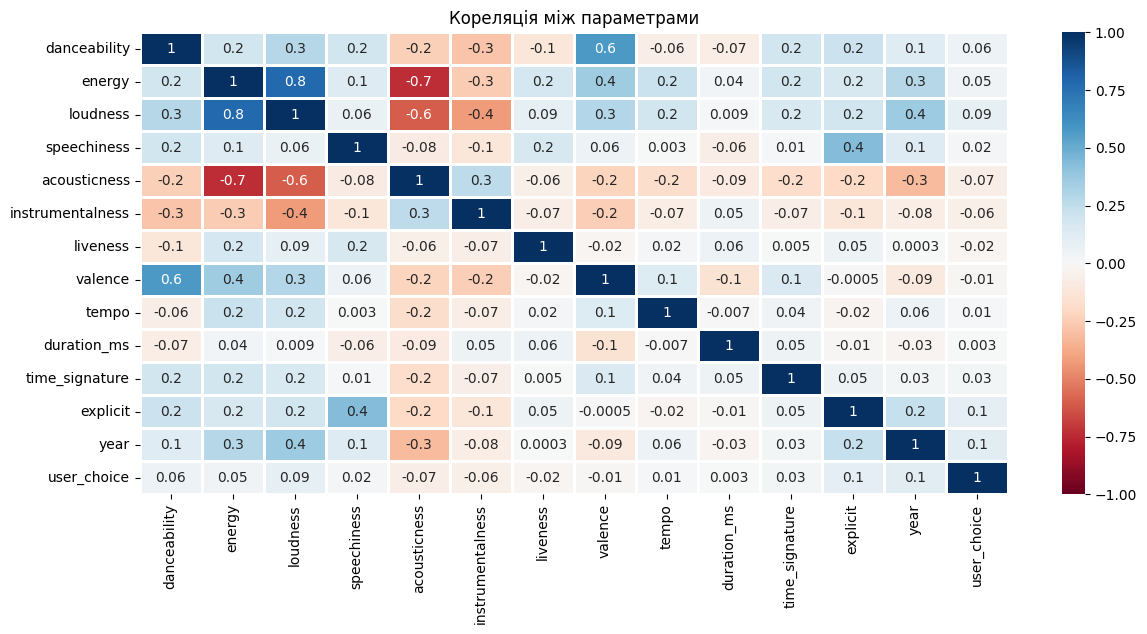

In [77]:
corr_df = df_track_features.drop(["name", "type", "release_date", "key","mode", "id", "artists"], axis=1).corr(method="pearson")
plt.figure(figsize=(14,6))

heatmap = sns.heatmap(corr_df, annot=True, fmt=".1g", vmin=-1, vmax=1, center=0, linewidths=1, cmap='RdBu')
heatmap.set_title("Кореляція між параметрами")
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)

In [78]:
df_track_features.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,id,duration_ms,time_signature,name,artists,type,explicit,year,release_date,user_choice
0,0.424,0.245,5,-11.470,1,0.0397,0.996000,0.799000,0.2350,0.4770,...,3HnrHGLE9u2MjHtdobfWl9,198627,4,Crazy Blues - 78rpm Version,['Mamie Smith & Her Jazz Hounds'],track,0,1920,1920,0.0001
1,0.730,0.798,2,-7.311,1,0.0425,0.000173,0.801000,0.1280,0.0422,...,19Lc5SfJJ5O1oaxY0fpwfh,422087,4,True House Music - Xavier Santos & Carlos Gomi...,['Oscar Velazquez'],track,0,1920,1920-01-01,0.0001
2,0.823,0.215,7,-20.204,1,0.0635,0.000669,0.090600,0.0715,0.8570,...,4HDguZ5btEwwmBrzNtDz7z,208867,4,Just Be Good To Me,['Claudia Robine'],track,0,1920,1920-01-03,0.0001
3,0.400,0.222,0,-11.340,1,0.0515,0.988000,0.883000,0.2080,0.4340,...,3gQPnyfPWDkZP8iuask2cO,88000,4,"Turbo OutRun Theme (From ""Turbo Outrun"") [Gene...",['FPS Allstars'],track,0,1920,1920-01-04,0.0001
4,0.275,0.309,5,-9.316,1,0.0354,0.967000,0.000028,0.3810,0.1650,...,3ftBPsC5vPBKxYSee08FDH,210000,3,Danny Boy,['Frank Parker'],track,0,1921,1921,0.0001
